In [11]:
import gymnasium as gym
import numpy as np
import random
import matplotlib.pyplot as plt
from IPython.display import clear_output
from time import sleep
from matplotlib import animation
import pygame
from contextlib import closing
from io import StringIO
from os import path
from typing import Optional

from gym import Env, logger, spaces, utils
from gym.envs.toy_text.utils import categorical_sample
from gym.error import DependencyNotInstalled




In [ ]:
MAP = [
    "+-------------+",
    "|M: : : : :B|F|",
    "| : : : : : : |",
    "|M: |-:-: : |B|",
    "|R:B| : : :-| |",
    "|-:-| : :M: :B|",
    "| : : :-:-: :-|",
    "|P: : : :R:M:L|",
    "+-------------+",
]
WINDOW_SIZE = (526,350)

class GameEnv(Env):
   

    metadata = {
        "render_modes": ["human", "ansi", "rgb_array"],
        "render_fps": 4,
    }

    def __init__(self, render_mode: Optional[str] = None):
        self.desc = np.asarray(MAP, dtype="c")
        self.start = (6, 0)
        self.restricted = {(3, 0), (6, 4)}
        self.finishLine =(0, 6)
        self.loot = (6,6)
        self.bossloc =[(0,5),(2,6),(3,1),(4,6)]
        self.miniBossLoc = [(0,0), (0,2), (4,4), (6,5)]
        
        # These are initialized to None here but will be assigned random locations/values every time self.reset() is called.
        
        self.current_loot_loc = None
        self.current_extra_loot_loc = None
        self.current_boss_loc = None
        self.game_imgs = None
        self.game_orientation = 0
        self.passenger_img = None
        self.destination_img = None
        self.walls = None
        self.background_img = None
        self.player_img = None
        self.loot_image = None
        self.boss_img = None
        self.walls_img = None
        self.miniBoss_img = None
        self.finishLine_img = None 
        self.restricted_img = None 
        
        # This will hold the valid locations for the boss and the mini boss to spawn.
        self.valid_boss_locations = []
        self.valid_mini_boss_locations = []
   
        self.bossColors = [(62, 0, 186), (175, 0, 6), (175, 125, 81), (63, 124, 16)]
        self.miniBossColors = [(170, 76, 0), (200, 150, 35), (72, 186, 126), (140, 0, 182)]
        num_states = 25088 #7x7(map)x4(boss)x4(mini boss)x4(health)x8(boss/miniboss/loot)
        self.num_rows = 7
        self.num_columns = 7
        self.max_row = self.num_rows - 1    
        self.max_col = self.num_columns - 1
        self.initial_state_distrib = np.zeros(num_states)
        # 0: South, 1: North, 2: East, 3: West, 4: Attack = 5 actions
        num_actions = 5
        # This tells the agent exactly what happens for every possible move in every possible situation.
        self.P = {
            state: {action: [] for action in range(num_actions)}
            for state in range(num_states)
        }
        for r in range(self.num_rows):
            for c in range(self.num_columns):
                if (r, c) not in [self.start, self.finishLine] and (r, c) not in self.restricted and (r, c)  in self.bossloc :
                    self.valid_boss_locations.append((r, c))
                elif (r, c) not in [self.start, self.finishLine] and (r, c) not in self.restricted and (r, c)  in self.miniBossLoc:
                    self.valid_mini_boss_locations.append((r, c))
        
        for row in range(self.num_rows):
            for col in range(self.num_columns):
                for boss_idx in range(len(self.bossloc)):  
                    for mini_boss_idx in range(len(self.miniBossLoc)):
                        for has_loot in range(2):
                            for has_mini in range(2):
                                for boss_alive in range(2):
                                    for health in range(1, 4):  # Health: 1, 2, 3
                                        state = self.encode(row, col, boss_idx, mini_boss_idx, 
                                                            has_loot, has_mini, boss_alive, health)
                
                                        # Only allow initial game positions that are not restricted 
                                        if (row, col) == self.start and has_loot == 0 and \
                                         has_mini == 0 and boss_alive == 1 and health == 3:
                                         self.initial_state_distrib[state] += 1
                                            
                                        for action in range(num_actions):
                                            new_row, new_col = row, col
                                            new_has_loot = has_loot
                                            new_has_mini = has_mini
                                            new_boss_alive = boss_alive
                                            new_health = health
                                            reward =( -1 ) # Step penalty
                                            terminated = False
                                            player_loc = (row, col)
                                            
                                            # Movement actions : also checks if the move is valid 
                                            if action == 0:  # South
                                                new_row = min(row + 1, self.max_row)
                                                if (new_row, col) in self.restricted or \
                                                not self._can_move(row, col, new_row, col):
                                                    new_row = row
                                            
                                            elif action == 1:  # North
                                                new_row = max(row - 1, 0)
                                                if (new_row, col) in self.restricted or \
                                                not self._can_move(row, col, new_row, col):
                                                    new_row = row
                                            
                                            elif action == 2:  # East
                                                new_col = min(col + 1, self.max_col)
                                                if (row, new_col) in self.restricted or \
                                                not self._can_move(row, col, row, new_col):
                                                    new_col = col
                                            
                                            elif action == 3:  # West
                                                new_col = max(col - 1, 0)
                                                if (row, new_col) in self.restricted or \
                                                not self._can_move(row, col, row, new_col):
                                                    new_col = col
                                            current_boss_loc = self.bossloc[boss_idx]
                                            current_mini_loc = self.miniBossLoc[mini_boss_idx]
                                            # Check for loot collection after movement
                                            new_player_loc = (new_row, new_col)
                                            if new_player_loc == self.loot and new_has_loot == 0:  # Collect loot if it hasn't been collected
                                                new_has_loot = 1
                                                reward += 10  # Loot collected reward !
                                            
                                            # Attack action (4)
                                            if action == 4:
                                                if player_loc == current_boss_loc and boss_alive == 1:  # Attack boss if alive
                                                    if has_loot == 1:
                                                        # Can damage boss only if the loot was collected 
                                                        damage = 2 if has_mini == 1 else 1
                                                        if damage >= 2:  # boss defeated
                                                            new_boss_alive = 0
                                                            reward += 20  # Boss defeated reward !
                                                    else:
                                                        # Attack without loot ( take damage )
                                                        new_health = max(0, health - 1)
                                                        reward -= 15  # Life loss
                                                        if new_health == 0:
                                                            terminated = True
                                                            reward -= 20  # Death penalty
                                                elif player_loc == current_mini_loc and has_mini == 0:
                                                    # Killing mini boss
                                                    new_has_mini = 1
                                                    reward += 10 # Mini boss killed reward !
                                                else:
                                                    reward -= 2  # Wasted attack
                                            
                                            # Check finish line
                                            if new_player_loc == self.finishLine:
                                                if new_boss_alive == 0:
                                                    reward += 30  # Mission complete !
                                                    terminated = True
                                                else:
                                                    reward -= 20 # Boss still alive, go back !
                                                    self.player_row, self.player_col = row, col # Push back
                                            
                                            # Death condition
                                            if new_health == 0:
                                                terminated = True
                                            
                                            new_state = self.encode(new_row, new_col, boss_idx, mini_boss_idx,new_has_loot, 
                                                                new_has_mini, new_boss_alive, new_health)
                                            
                                            self.P[state][action].append(
                                                (1.0, new_state, reward, terminated)
                                            )
        self.initial_state_distrib /= self.initial_state_distrib.sum()
        self.action_space = spaces.Discrete(num_actions)
        self.observation_space = spaces.Discrete(num_states)

        self.render_mode = render_mode

        # pygame utils
        self.window = None
        self.cell_size = (
            WINDOW_SIZE[0] / self.num_columns,
            WINDOW_SIZE[1] / self.num_rows,
        )
        self.game_imgs = None
        self.game_orientation = 0
        self.passenger_img = None
        self.destination_img = None
        self.walls = None
        self.walls = None
        self.background_img = None
        
        
    def _can_move(self, from_row, from_col, to_row, to_col):
        # Check if movement is allowed (no walls blocking)
        if from_col == to_col:
            if to_row > from_row:  # Moving south
                return self.desc[1 + from_row + 1, 2 * from_col + 1] != b"-"
            else:  # Moving north
                return self.desc[1 + from_row, 2 * from_col + 1] != b"-"
        elif from_row == to_row:
            if to_col > from_col:  # Moving east
                return self.desc[1 + from_row, 2 * from_col + 2] == b":"
            else:  # Moving west
                return self.desc[1 + from_row, 2 * from_col] == b":"
        return True
    
    def encode(self, row, col, boss_idx, mini_boss_idx,has_loot, has_mini, boss_alive, health):
        #Encode state as single integer
        i = row
        i *= 7 # num_columns
        i += col
        i *= 4  # boss_idx (0-3)
        i += boss_idx
        i *= 4  # mini_boss_idx (0-3)
        i += mini_boss_idx
        i *= 2  # has_loot (0 or 1)
        i += has_loot
        i *= 2  # has_mini (0 or 1)
        i += has_mini
        i *= 2  # boss_alive (0 or 1)
        i += boss_alive
        i *= 4  # health (0-3)
        i += health
        return i

    def decode(self, i):
        #Decode integer state to components
        out = []
        out.append(i % 4)  # health
        i = i // 4
        out.append(i % 2)  # boss_alive
        i = i // 2
        out.append(i % 2)  # has_mini
        i = i // 2
        out.append(i % 2)  # has_loot
        i = i // 2
        out.append(i % 4)  # mini_boss_idx
        i = i // 4
        out.append(i % 4)  # boss_idx
        i = i // 4
        out.append(i % 7)  # col
        i = i // 7
        out.append(i)  # row
        return reversed(out)

    def action_mask(self, state: int):
        #Computes an action mask for the action space using the state information.
        #This prevents the agent from trying to walk through walls and lava or attach empty air.
    

        mask = np.zeros(5, dtype=np.int8)
        
        # Decode the state back into game variables
        row, col, boss_idx, mini_boss_idx, has_loot, has_mini, boss_alive, health = self.decode(state)
        
        # MOVEMENT MASKS 
        # South
        if row < self.max_row and (row + 1, col) not in self.restricted:

            mask[0] = 1
        # North
        if row > 0 and (row - 1, col) not in self.restricted:
            mask[1] = 1
        # East
        if col < self.max_col and (row, col + 1) not in self.restricted:
            mask[2] = 1
        # West
        if col > 0 and (row, col - 1) not in self.restricted:
            mask[3] = 1

        #  ATTACK MASK 
        # We need to know where the bosses actually are based on the indices
        real_main_loc = self.bossloc[boss_idx]      # Use boss_idx from decode(state)
        real_mini_loc = self.miniBossLoc[mini_boss_idx] # Use mini_boss_idx from decode(state)
        player_loc = (row, col)

        #  Attack ONLY if we are standing on a LIVE boss
        if player_loc == real_main_loc and boss_alive == 1:
            mask[4] = 1
        elif player_loc == real_mini_loc:
             #check if the mini boss is alive 
             if has_mini == 0: 
                 mask[4] = 1
        
        return mask

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        
        # Reset Player
        self.player_row, self.player_col = self.start
        
        # Randomize Boss Locations (Pick Index 0-3)
        self.main_idx = random.randint(0, 3)
        self.mini_idx = random.randint(0, 3)
        
        # Reset Status Flags
        self.has_loot = 0
        self.has_mini = 0
        self.boss_alive = 1 
        self.mini_alive = 1 
        self.mini_alive = 1
        self.health = 3
        

        self.s = self.encode(self.player_row, self.player_col, 
                            self.main_idx, self.mini_idx,
                            self.has_loot, self.has_mini, 
                            self.boss_alive, self.health)
        if self.render_mode == "human":
            self.render()
        return int(self.s), {}

    def step(self, action):
        row, col = self.player_row, self.player_col
        reward = -1 # Step penalty
        terminated = False
        
        new_row, new_col = row, col

        # MOVEMENT LOGIC (0-3) 
        if action == 0: new_row = min(row + 1, self.max_row) # South
        elif action == 1: new_row = max(row - 1, 0) # North
        elif action == 2: new_col = min(col + 1, self.max_col) # East
        elif action == 3: new_col = max(col - 1, 0) # West
        
        # Map Boundary check (I had some problems with the character getting out of the boundries)
        new_row = max(0, min(new_row, self.max_row))
        new_col = max(0, min(new_col, self.max_col))

        # Check Walls / Restricted Areas
        if (new_row, new_col) in self.restricted or not self._can_move(row, col, new_row, new_col):
            new_row, new_col = row, col # Bounce back
            
        self.player_row, self.player_col = new_row, new_col
        loc = (new_row, new_col)

        # Retrieve ACTUAL boss locations from the indices
        real_main_loc = self.bossloc[self.main_idx]
        real_mini_loc = self.miniBossLoc[self.mini_idx]
        
        #  GAMEPLAY LOGIC
        
        # Loot
        if loc == self.loot and self.has_loot == 0:
            self.has_loot = 1
            reward += 10
        
        # Mini Boss (Need to kill for Extra Power)
        if loc == real_mini_loc and self.mini_alive == 1:
            if action == 4: # Attack
                self.mini_alive = 0
                self.has_mini = 1 # Gain Power
                reward += 10
            else:
                reward -= 2 # Standing on enemy hurts
        
        # Main Boss (Need Loot + Extra Power to kill)
        if loc == real_main_loc and self.boss_alive == 1:
            if action == 4: # Attack
                if self.has_loot == 1 and self.has_mini == 1:
                    self.boss_alive = 0
                    reward += 30 # BIG REWARD !
                else:
                    self.health -= 1 # Not strong enough
                    reward -= 15
                    if self.health <= 0:
                        terminated = True
                        reward -= 20
                        self.health = 0
            else:
                reward -= 2 # Standing on enemy hurts
        
        
        # died?
        if self.health <= 0:
            terminated = True
            reward -= 20
            self.health = 0
            
        # Reached the finish line ?
        if loc == self.finishLine:
            if self.boss_alive == 0:
                reward += 30 # WIN
                terminated = True
            else:
                reward -= 20 # Boss still alive, go back!
                self.player_row, self.player_col = row, col # Push back

        self.s = self.encode(self.player_row, self.player_col, 
                            self.main_idx, self.mini_idx,
                            self.has_loot, self.has_mini, 
                            self.boss_alive, self.health)
      
        return int(self.s), reward, terminated, False, {}

    def render(self):
        if self.render_mode is None:
            logger.warn(
                "You are calling render method without specifying any render mode. "
                "You can specify the render_mode at initialization, "
                f'e.g. gym("{self.spec.id}", render_mode="rgb_array")'
            )
        if self.render_mode == "ansi":
            return self._render_text()
        else:  # self.render_mode in {"human", "rgb_array"}:
            return self._render_gui(self.render_mode)
        
        
    def _render_gui(self, mode):
        if self.window is None:
            pygame.init()
            pygame.display.set_caption("Player")
            if mode == "human":
                self.window = pygame.display.set_mode(WINDOW_SIZE)
            elif mode == "rgb_array":
                self.window = pygame.Surface(WINDOW_SIZE)

        if self.cell_size is None or self.cell_size[0] < 10: 
            self.cell_size = (
                WINDOW_SIZE[0] / self.num_columns, 
                WINDOW_SIZE[1] / self.num_rows,   
            )
            
        # LOAD IMAGES 
        if self.player_img is None:
            self.player_img = pygame.transform.scale(pygame.image.load(path.join(".", "img/mario.png")), self.cell_size)
        if self.loot_image is None:
            self.loot_image = pygame.transform.scale(pygame.image.load(path.join(".", "img/gold.png")), self.cell_size)
        if self.boss_img is None:
            self.boss_img = pygame.transform.scale(pygame.image.load(path.join(".", "img/main-boss.png")), self.cell_size)
        if self.miniBoss_img is None:
            self.miniBoss_img = pygame.transform.scale(pygame.image.load(path.join(".", "img/mini-boss.png")), self.cell_size)
        if self.finishLine_img is None:
            img = pygame.image.load(path.join(".", "img/princessPeach.png"))
            self.finishLine_img = pygame.transform.scale(img, self.cell_size)
        if self.walls_img is None:
            self.walls_img = pygame.transform.scale(pygame.image.load(path.join(".","img/mario_wall.png")), self.cell_size) 
        if self.background_img is None:
            self.background_img = pygame.transform.scale(pygame.image.load(path.join(".", "img/background2.png")), self.cell_size)
        if self.restricted_img is None:
            self.restricted_img = pygame.transform.scale(pygame.image.load(path.join(".", "img/lava.png")), self.cell_size)
            
        # I made the walls thin for the internal separators (squash the brick image into thin strips)
        wall_thickness = 8
        vertical_wall = pygame.transform.scale(self.walls_img, (wall_thickness, int(self.cell_size[1])))
        horizontal_wall = pygame.transform.scale(self.walls_img, (int(self.cell_size[0]), wall_thickness))

        def get_pos(r, c):
            return (c * self.cell_size[0], r * self.cell_size[1])

        # LAYER 1: FLOOR (Background)
        for r in range(self.num_rows):
            for c in range(self.num_columns):
                pos = get_pos(r, c)
                self.window.blit(self.background_img, pos)

        # LAYER 2: RESTRICTED AREAS ("Lava")
        for r, c in self.restricted:
            pos = get_pos(r, c)
            self.window.blit(self.restricted_img, pos)
   
        # LAYER 3: INTERNAL WALLS (From MAP)
        desc = self.desc
        
        # iterate through the game grid (0-6)
        for r in range(self.num_rows):
            for c in range(self.num_columns):
                pos = get_pos(r, c)
                
                # Check the map for walls. 
                # Map Row = r + 1 (skip top border)
                # Map Col Center = 2*c + 1 (skip left border )
                
                ascii_row = r + 1
                ascii_col_idx = 2 * c + 1
                
                # Vertical wall  "|"
                # In ASCII, the right wall is at index +1 from center
                # only draw if it is NOT the map border (c < 6)
                if c < self.max_col:
                    if desc[ascii_row][ascii_col_idx + 1] == b"|":
                        self.window.blit(vertical_wall, (pos[0] + self.cell_size[0] - (wall_thickness/2), pos[1]))

                #Horizontal wall  "-"
                # In ASCII, the bottom wall is at row +1
                # only draw if it is NOT the map border (r < 6)
                if r < self.max_row:
                    if desc[ascii_row + 1][ascii_col_idx] == b"-":
                        self.window.blit(horizontal_wall, (pos[0], pos[1] + self.cell_size[1] - (wall_thickness/2)))

        # SPAWN LOCATIONS (Colored cells) 
        for cell, color in zip(self.valid_boss_locations, self.bossColors):
            color_cell = pygame.Surface(self.cell_size)
            color_cell.set_alpha(100) 
            color_cell.fill(color)
            self.window.blit(color_cell, self.get_surf_loc(cell))

        for cell, color in zip(self.valid_mini_boss_locations, self.miniBossColors):
            color_cell = pygame.Surface(self.cell_size)
            color_cell.set_alpha(100)
            color_cell.fill(color)
            self.window.blit(color_cell, self.get_surf_loc(cell))

        # LAYER 5: ENTITIES (Finish line, Loot, Mini-boss, Main-boss)   
        row, col, main_idx, mini_idx, has_loot, has_mini, boss_alive, health = self.decode(self.s)

        self.window.blit(self.finishLine_img, get_pos(*self.finishLine))
        if has_loot == 0:
            self.window.blit(self.loot_image, get_pos(*self.loot))
        if self.mini_alive == 1:
            self.window.blit(self.miniBoss_img, get_pos(*self.miniBossLoc[mini_idx]))
        if boss_alive == 1:
            self.window.blit(self.boss_img, get_pos(*self.bossloc[main_idx]))
        
        # Player
        self.window.blit(self.player_img, get_pos(row, col))

        # FINAL OUTPUT
        if mode == "human":
            pygame.event.pump() 
            pygame.display.update()
        elif mode == "rgb_array":
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.window)), axes=(1, 0, 2)
            )
        if self.window is None:
            pygame.init()
            pygame.display.set_caption("Player")
            if mode == "human":
                self.window = pygame.display.set_mode(WINDOW_SIZE)
            elif mode == "rgb_array":
                self.window = pygame.Surface(WINDOW_SIZE)

        if self.cell_size is None or self.cell_size[0] < 10: 
            self.cell_size = (
                WINDOW_SIZE[0] / self.num_columns, 
                WINDOW_SIZE[1] / self.num_rows,   
            )
            
        # Load images (using fixed paths)
        if self.player_img is None:
            self.player_img = pygame.transform.scale(pygame.image.load(path.join(".", "img/mario.png")), self.cell_size)
        if self.loot_image is None:
            self.loot_image = pygame.transform.scale(pygame.image.load(path.join(".", "img/gold.png")), self.cell_size)
        if self.boss_img is None:
            self.boss_img = pygame.transform.scale(pygame.image.load(path.join(".", "img/main-boss.png")), self.cell_size)
        if self.miniBoss_img is None:
            self.miniBoss_img = pygame.transform.scale(pygame.image.load(path.join(".", "img/mini-boss.png")), self.cell_size)
        if self.finishLine_img is None:
            img = pygame.image.load(path.join(".", "img/princessPeach.png"))
            self.finishLine_img = pygame.transform.scale(img, self.cell_size)
        if self.walls_img is None:
            self.walls_img = pygame.transform.scale(pygame.image.load(path.join(".","img/mario_wall.png")), self.cell_size) 
        if self.background_img is None:
            self.background_img = pygame.transform.scale(pygame.image.load(path.join(".", "img/background2.png")), self.cell_size)
        if self.restricted_img is None:
            self.restricted_img = pygame.transform.scale(pygame.image.load(path.join(".", "img/lava.png")), self.cell_size)
            
        # DRAWING 
        desc = self.desc
        for y in range(0, desc.shape[0]):
            for x in range(0, desc.shape[1]):
                cell = (x * self.cell_size[0], y * self.cell_size[1])
                self.window.blit(self.background_img, cell)
                
                # Draw walls  
                if desc[y][x] == b"|" and (y == 0 or desc[y - 1][x] != b"|"):
                    self.window.blit(self.walls_img, cell)
                elif desc[y][x] == b"|" and (y == desc.shape[0] - 1 or desc[y + 1][x] != b"|"):
                    self.window.blit(self.walls_img, cell)
                elif desc[y][x] == b"|":
                    self.window.blit(self.walls_img, cell)  
                elif desc[y][x] == b"-" and (x == 0 or desc[y][x - 1] != b"-"):
                    self.window.blit(self.walls_img, cell)
                elif desc[y][x] == b"-" and (x == desc.shape[1] - 1 or desc[y][x + 1] != b"-"):
                    self.window.blit(self.walls_img, cell)
                elif desc[y][x] == b"-":
                    self.window.blit(self.walls_img, cell)

        # Draw Locations
        for cell, color in zip(self.valid_boss_locations, self.bossColors):
            color_cell = pygame.Surface(self.cell_size)
            color_cell.set_alpha(128)
            color_cell.fill(color)
            loc = self.get_surf_loc(cell)
            self.window.blit(color_cell, (loc[0], loc[1] + 10))

        for cell, color in zip(self.valid_mini_boss_locations, self.miniBossColors):
            color_cell = pygame.Surface(self.cell_size)
            color_cell.set_alpha(128)
            color_cell.fill(color)
            loc = self.get_surf_loc(cell)
            self.window.blit(color_cell, (loc[0], loc[1] + 10))
            
        for cell in self.restricted:
            restricted_cell = pygame.Surface(self.cell_size)
            loc = self.get_surf_loc(cell)
            self.window.blit(self.restricted_img, (loc[0], loc[1] + 10))

        # DRAW ENTITIES (Finish line, Loot, Mini-boss, Main-boss)   
        row, col, main_idx, mini_idx, has_loot, has_mini, boss_alive, health = self.decode(self.s)

        def get_pos(r, c):
            return (c * self.cell_size[0], r * self.cell_size[1])
        
        self.window.blit(self.finishLine_img, get_pos(*self.finishLine))
        if has_loot == 0:
            self.window.blit(self.loot_image, get_pos(*self.loot))
        if self.mini_alive == 1:
            self.window.blit(self.miniBoss_img, get_pos(*self.miniBossLoc[mini_idx]))
        if boss_alive == 1:
            self.window.blit(self.boss_img, get_pos(*self.bossloc[main_idx]))
        
        # Player
        self.window.blit(self.player_img, get_pos(row, col))

        if mode == "human":
            pygame.event.pump() # Keeps the window responsive
            pygame.display.update()
        elif mode == "rgb_array":
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.window)), axes=(1, 0, 2)
            )
    def get_surf_loc(self, map_loc):
       # Converts grid (row, col) to pixel coordinates (x, y)
        return (map_loc[1] * self.cell_size[0], map_loc[0] * self.cell_size[1])
    def _render_text(self):
        desc = self.desc.copy().tolist()
        outfile = StringIO()

        out = [[c.decode("utf-8") for c in line] for line in desc]
        
        # Decode the full state
        row, col, main_idx, mini_idx, has_loot, has_extra, boss_alive, health = self.decode(self.s)

        #Place Walls (X)
        for r, c in self.restricted:
            out[1 + r][2 * c + 1] = "X"

        #Place Finish Line (F)
        fr, fc = self.finishLine 
        out[1 + fr][2 * fc + 1] = utils.colorize("F", "green", highlight=True)

        #Place Loot (L) 
        if has_loot == 0:
            lr, lc = self.loot
            out[1 + lr][2 * lc + 1] = utils.colorize("L", "cyan", bold=True)

        #Place Mini Boss (m) 
        if has_extra == 0:
            mr, mc = self.miniBossLoc[mini_idx]
            out[1 + mr][2 * mc + 1] = utils.colorize("m", "yellow", bold=True)

        #Place Main Boss (B) 
        if boss_alive == 1:
            br, bc = self.bossloc[main_idx]
            out[1 + br][2 * bc + 1] = utils.colorize("B", "red", highlight=True)

        #Place Player (P) 
        # If player is on top of something, overwrite it (showing the player)
        out[1 + row][2 * col + 1] = utils.colorize("P", "blue", highlight=True)

        outfile.write("\n".join(["".join(row) for row in out]) + "\n")
        
        # Add Status Text
        outfile.write(f"Health: {health} | Loot: {'Yes' if has_loot else 'No'} | Power: {'Yes' if has_extra else 'No'}\n")
        
        if self.lastaction is not None:
            outfile.write(f"  ({['South', 'North', 'East', 'West', 'Attack'][self.lastaction]})\n")
        else:
            outfile.write("\n")

        with closing(outfile):
            return outfile.getvalue()
    def close(self):
        if self.window is not None:
            import pygame

            pygame.display.quit()
            pygame.quit()


In [13]:
def run_animation(experience_buffer):
    """Function to run animation"""
    time_lag = 0.1  # Delay (in s) between frames
    for experience in experience_buffer:
        # Plot frame
        clear_output(wait=True)
        plt.imshow(experience['frame'])
        plt.axis('off')
        plt.title(f"Episode: {experience['episode']} | Step: {experience['epoch']} | Reward: {experience['reward']:.1f}")
        plt.show()

        # Print console output
        print(f"Episode: {experience['episode']}")
        print(f"Step: {experience['epoch']}")
        print(f"State: {experience['state']}")
        print(f"Action: {experience['action']}")
        print(f"Cumulative Reward: {experience['reward']:.1f}")

        # Pause animation
        sleep(time_lag)
       

In [14]:
def store_episode_as_gif(experience_buffer,path='./', filename='dungeon_animation.gif'):
    """Store episode as gif animation with dynamic titles"""
    fps = 5   # Frames per second
    dpi = 72  # Dots per inch
    interval = 200  # Interval between frames (in ms)

    if len(experience_buffer) == 0:
        print("No frames to save!")
        return

    # Use the first frame to set up the plot dimensions
    first_frame = experience_buffer[0]['frame']

    # Fix frame size
    plt.figure(figsize=(first_frame.shape[1] / dpi, first_frame.shape[0] / dpi), dpi=dpi)
    patch = plt.imshow(first_frame)
    plt.axis('off')

    
    def animate(i):
        # Get the specific data for this frame (i)
        data = experience_buffer[i]
        
        # Update the image
        patch.set_data(data['frame'])
        
        # Update the title dynamically

        plt.title(f"Episode: {data['episode']} | Step: {data['epoch']} | Reward: {data['reward']:.1f}")

    # Create the animation using the length of the buffer
    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(experience_buffer), interval=interval)


    # Save output as gif
    anim.save(path + filename, writer='imagemagick', fps=fps)

State space: Discrete(25088)
Action space: Discrete(5)


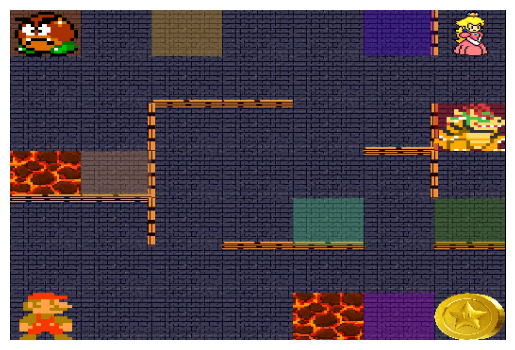

State: 21639
Action: 1
Action mask: [0 1 1 0 0]
Reward: -1


In [15]:
"""Initialize and validate the environment"""
env = GameEnv(render_mode="rgb_array")
state, _ = env.reset()

# Print dimensions of state and action space
print("State space: {}".format(env.observation_space))
print("Action space: {}".format(env.action_space))

frame = env.render()
# Plot the initial frame first so the player start from the initial position
plt.imshow(frame)
plt.axis("off")
plt.show()  

# Sample random action
action = env.action_space.sample(env.action_mask(state))
next_state, reward, done, _, _ = env.step(action)

# Print output
print("State: {}".format(state))
print("Action: {}".format(action))
print("Action mask: {}".format(env.action_mask(state)))
print("Reward: {}".format(reward))




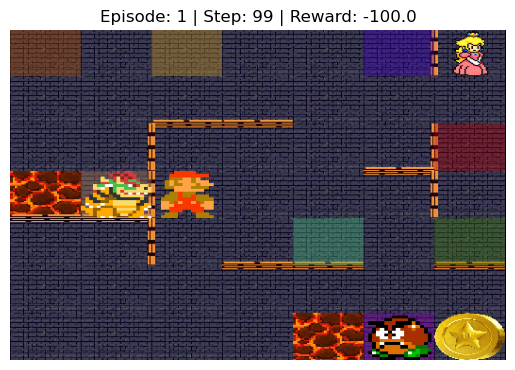

Episode: 1
Step: 99
State: 12135
Action: 3
Cumulative Reward: -100.0
Total Epochs: 100
Result: FAILED


In [16]:
"""Simulation with random agent"""
epoch = 0
num_failed_ending = 0
experience_buffer = []
cum_reward = 0
max_steps = 100  

done = False

state, _ = env.reset()

while not done and epoch < max_steps:
    # Sample random action
    action = env.action_mask(state) 
    action = env.action_space.sample(mask=env.action_mask(state))    
    
    state, reward, terminated, truncated, _ = env.step(action)
    
    # Check if simulation should end
    done = terminated or truncated
    
    cum_reward += reward

    # Store experience
    experience_buffer.append({
        "frame": env.render(),
        "episode": 1,
        "epoch": epoch,
        "state": state,
        "action": action,
        "reward": cum_reward,
        }
    )
    
    # Increment step counter
    epoch += 1

# Check Failure AFTER the loop finishes
# Failure = Timeout (epoch hit max_steps) OR Death (Terminated with negative reward)
if epoch >= max_steps:
    num_failed_ending = 1 # Failed due to Timeout
elif terminated and reward < 0:
    num_failed_ending = 1 # Failed due to Death

run_animation(experience_buffer)

print(f"Total Epochs: {epoch}")
print(f"Result: {'FAILED' if num_failed_ending == 1 else 'SUCCESS'}")

Episode: 100000 | Epsilon: 0.0500 | Last Reward: 67.70
Training Completed.


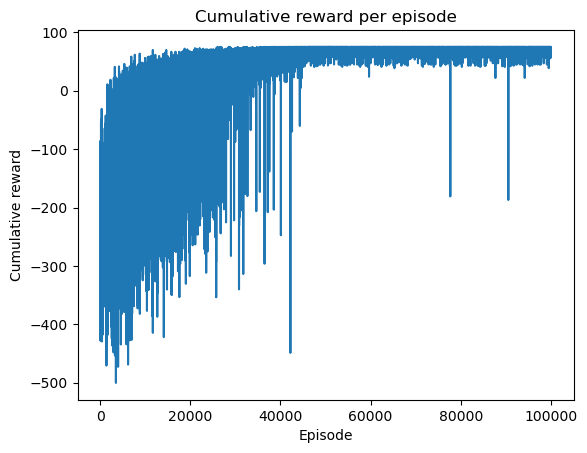

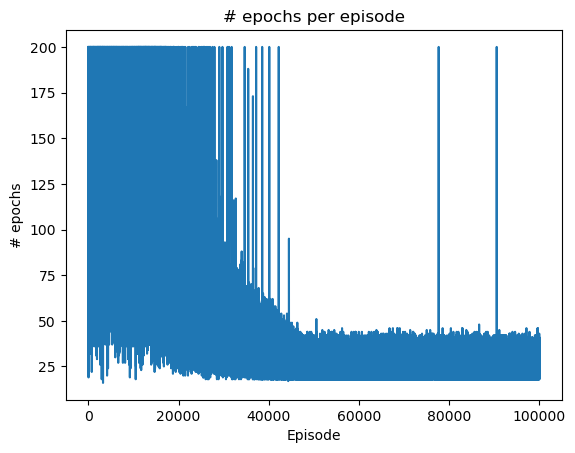

In [17]:
def calculate_shaping_reward(env, prev_state, curr_state):

    #Calculates a 'heuristic' reward. 
    #If the agent moves closer to the current objective -> +Reward
    #If the agent moves away -> -Reward
    
    # Decode states to get positions
    row, col, _, _, has_loot, has_mini, boss_alive, _ = env.decode(prev_state)
    new_row, new_col, _, _, _, _, _, _ = env.decode(curr_state)
    
    player_pos = (row, col)
    new_player_pos = (new_row, new_col)
    
    # Determine Current Objective
    target_pos = None
    
    if has_loot == 0:
        target_pos = env.loot
    elif has_mini == 0:
        #Access the internal random index of the mini boss
        target_pos = env.miniBossLoc[env.mini_idx]
    elif boss_alive == 1:
        # Access the internal random index of the main boss
        target_pos = env.bossloc[env.main_idx]
    else:
        target_pos = env.finishLine
        
    #Calculate Manhattan Distance
    prev_dist = abs(player_pos[0] - target_pos[0]) + abs(player_pos[1] - target_pos[1])
    new_dist = abs(new_player_pos[0] - target_pos[0]) + abs(new_player_pos[1] - target_pos[1])
    
    # Assign Reward
    if new_dist < prev_dist:
        return 0.5  # Getting Closer (Hot!)
    elif new_dist > prev_dist:
        return -0.6 # Getting Colder (Cold!) (slightly higher penalty to discourage loops)
    return 0

# MAIN TRAINING LOOP 

q_table = np.zeros([env.observation_space.n, env.action_space.n])

# Hyperparameters
alpha = 0.1
gamma = 0.9
epsilon = 1.0
min_epsilon = 0.05
epsilon_decay = 0.00002 
num_episodes = 100000  
max_steps_per_episode = 200 

# Output storage
cum_rewards = np.zeros([num_episodes])
total_epochs = np.zeros([num_episodes])

print("Starting Training ...")

for episode in range(1, num_episodes+1):
    state, info = env.reset()
    epoch = 0 
    cum_reward = 0
    done = False
    
    while not done:
        # Choose Action
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample(env.action_mask(state)) # Explore valid moves
        else:
            # Exploit: Choose best action, tie-break randomly
            best_val = np.max(q_table[state])
            # Get all actions that have the best value
            best_actions = [i for i, val in enumerate(q_table[state]) if val == best_val]
            # Use mask to ensure we don't pick an invalid wall-hit even if Q is high
            mask = env.action_mask(state)
            valid_best_actions = [a for a in best_actions if mask[a] == 1]
            
            if not valid_best_actions: # Fallback if all best are invalid (rare)
                 action = env.action_space.sample(mask)
            else:
                action = random.choice(valid_best_actions)

        # Take Action
        next_state, reward, terminated, truncated, _ = env.step(action)
        # Check if done (either died/won or timed out by env)
        done = terminated or truncated
        
        # Manually force timeout ... if needed
        if epoch >= max_steps_per_episode:
            done = True
            truncated = True
        
        shaping = calculate_shaping_reward(env, state, next_state)
        total_reward = reward + shaping

        cum_reward += total_reward 

        # Update Q-Table
        old_q = q_table[state, action]
        next_max = np.max(q_table[next_state])
        
        new_q = (1 - alpha) * old_q + alpha * (total_reward + gamma * next_max)
        q_table[state, action] = new_q
        
        state = next_state
        epoch += 1
        
        if epoch >= max_steps_per_episode:
            done = True
            
    # Decay epsilon
    epsilon = max(min_epsilon, epsilon - epsilon_decay)
        
    total_epochs[episode-1] = epoch
    cum_rewards[episode-1] = cum_reward

    if episode % 1000 == 0:
        clear_output(wait=True)
        print(f"Episode: {episode} | Epsilon: {epsilon:.4f} | Last Reward: {cum_reward:.2f}")

print("Training Completed.")

# Plot results
plt.title("Cumulative reward per episode")
plt.xlabel("Episode")
plt.ylabel("Cumulative reward")
plt.plot(cum_rewards)
plt.show()

plt.title("# epochs per episode")
plt.xlabel("Episode")
plt.ylabel("# epochs")
plt.plot(total_epochs)
plt.show()

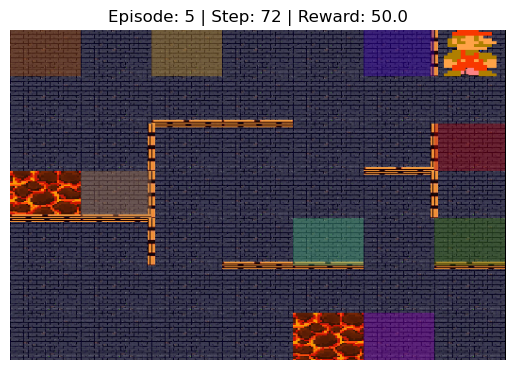

Episode: 5
Step: 72
State: 3483
Action: 1
Cumulative Reward: 50.0


Test results after 5 episodes:
Mean # epochs per episode: 0.0
Mean # failed endings per episode: 0.0


In [18]:
"""Test policy performance after training"""

# use saved Q-table
q_table = np.loadtxt('game_q_table.csv', delimiter=',') 

num_epochs = 0
total_failed_ending = 0
total_epochs_test = 0
num_episodes = 5
experience_buffer = []
max_test_steps = 80

for episode in range(1, num_episodes+1):


    my_env = env.reset()
    state = my_env[0]
    epoch = 1 
    num_failed_ending =0
    cum_reward = 0
    done = False
    is_failure = False

    while not done:
        action = np.argmax(q_table[state])
        state, reward, terminated, truncated, info = env.step(action)
        cum_reward += reward
        epoch +=1
        # Check Timeout
        if epoch >= max_test_steps:
            truncated = True
            
        done = terminated or truncated

        # Timeout failure
        if truncated:
            is_failure = True
        # Death failure 
        # Win > 0 and Death < 0
        elif terminated and reward < 0:
            is_failure = True

        # Store rendered frame in animation dictionary
        experience_buffer.append({
            'frame': env.render(),
            'episode': episode,
            'epoch': epoch,
            'state': state,
            'action': action,
            'reward': cum_reward
            }
        )

        epoch += 1

    if is_failure:
        total_failed_ending += 1
        
    total_epochs_test += epoch


    store_episode_as_gif(experience_buffer)

# Run animation and print output
run_animation(experience_buffer)

# Print final results
print("\n") 
print(f"Test results after {num_episodes} episodes:")
print(f"Mean # epochs per episode: {num_epochs / num_episodes}")
print(f"Mean # failed endings per episode: {total_failed_ending / num_episodes}")